# ISTAT mortality data

In this project we analyze the mortality data from the Italian National Institute of Statistics (ISTAT). First we clean up and reorganize the daily mortality records; then we fit models to estimate the excess mortality in years 2020-2021, and plot the results for different regions and age classes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw=pd.read_csv('data_nov24.csv',encoding='latin-1')

The original file is a 4-million-rows file containing daily deaths from 2011 to 2023 with specified location and age class, found at the following link:

https://www.istat.it/it/archivio/240401 > (4) Dataset con i decessi giornalieri (formato .csv)

We start by cleaning it up by removing some data we will not need.

In [4]:
raw_drop=raw.drop(['REG','PROV','NOME_COMUNE','COD_PROVCOM','TIPO_COMUNE'],axis=1)

## Data processing

In [5]:
raw_drop.head()

,NOME_REGIONE,NOME_PROVINCIA,CL_ETA,GE,M_11,M_12,M_13,M_14,M_15,M_16,...,T_15,T_16,T_17,T_18,T_19,T_20,T_21,T_22,T_23,T_24
0,Piemonte,Torino,1,415,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Piemonte,Torino,6,1018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Piemonte,Torino,7,609,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,Piemonte,Torino,8,527,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Piemonte,Torino,9,201,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In the original csv file, the day and month of death are given in rows, while the years are each a different column;
we want the rows to index the full date as usual.

In [48]:
data2=raw_drop.copy()
last_year=24

#remove incomplete columns
data2.drop('M_{} F_{} T_{}'.format(last_year,last_year,last_year).split(' '),axis=1,inplace=True)
data2['GE']=data2['GE'].apply(lambda x: str(x)[:-2]+'/'+str(x)[-2:]) #format the day and month string as usual


yearly_dataframes=[]
start_year=15
for i in range(start_year,last_year-1):
    
    #for column of year 20XX, choose the rows where at least one death happened (=occurrences in a given day and place)
    year_i=data2[data2['M_{}'.format(i)] | data2['F_{}'.format(i)]!=0].rename(columns={'M_{}'.format(i):'M', 'F_{}'.format(i):'F'})
    
    #create a dataframe recording deaths in that year
    year_i=year_i[['NOME_REGIONE','NOME_PROVINCIA','CL_ETA','GE','M','F']]
    
    #add year to the day-month string, then covert it to datetime object
    year_i['GE']=year_i['GE'].apply(lambda x: '20'+'{}'.format(i)+'/'+x)
    year_i['GE']=pd.to_datetime(year_i['GE'])
    
    yearly_dataframes.append(year_i)    
full_data=pd.concat(yearly_dataframes,axis=0).set_index('GE') #concatenate each year of data in a single dataframe
full_data=full_data.rename(columns={'NOME_REGIONE':'region', 'NOME_PROVINCIA':'province', 'CL_ETA':'age_class'})
full_data.index.name='date'

#combine deaths happening in the same place, date and age class in a single row with the total number given in column M/F (male/female)
full_data=full_data.groupby(['date','region','province','age_class','M','F']).sum().reset_index().set_index('date')


## Save processed data

In [50]:
#save the new dataframe as csv
full_data.to_csv('processed.csv')

In [2]:
full_data=pd.read_csv('processed.csv',index_col=0)
full_data.index=pd.to_datetime(full_data.index)

In [3]:
full_data.head()

,region,province,age_class,M,F
date,,,,,
2015-01-01,Abruzzo,Chieti,9,1,0
2015-01-01,Abruzzo,Chieti,16,0,1
2015-01-01,Abruzzo,Chieti,16,1,0
2015-01-01,Abruzzo,Chieti,16,1,1
2015-01-01,Abruzzo,Chieti,17,0,1


## Overall excess mortality

Here we compute excess mortality as the percentage change between the observed deaths in a given month and the average number of deaths in that month over the previous x years, where x is usually 4 or 5 in the official reports (here we take 2 for demonstration purposes).

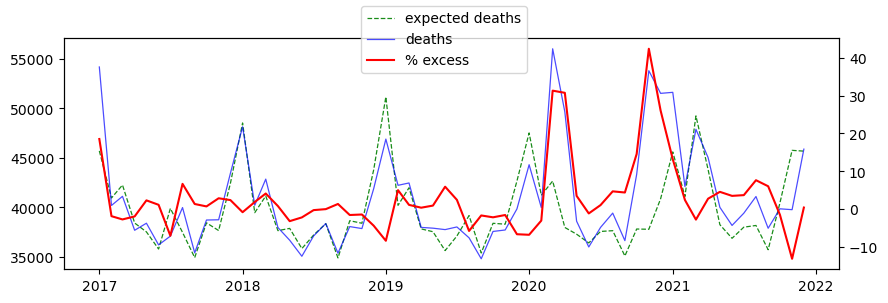

In [4]:
start_date='2015-01-01'
end_date='2021-12-31'
window=2 #number of years averaged to compute expected mortality

##################################################




full_data['T']=full_data['M']+full_data['F'] #total deaths = male + female
data_sliced=full_data.loc[start_date:end_date,'T']
x=data_sliced.groupby(pd.Grouper(freq='MS')).sum()

#for each month, compute expected mortality, i.e. average of previous [window] years:
reshaped=x.to_numpy().reshape(-1,12)
avg=pd.DataFrame(reshaped).rolling(window=window,closed='left').mean().round(2).dropna()
expected=pd.Series(avg.to_numpy().reshape(-1),index=x.index[12*window:])

#observed data:
observed=data_sliced.loc['{}-01-01'.format(int(start_date[:4])+window):].groupby([pd.Grouper(freq='MS')]).sum()

#percent excess mortality
pscore=100*((observed-expected)/expected)




### PLOTS ###############################################
#matplotlib.rc_file_defaults()
#sns.set_theme(style='darkgrid')
fig, ax= plt.subplots(figsize=(10,3))
fig.figsize=(10,3)
ax.plot(expected,'--',color='g',linewidth=0.9,label='expected deaths',alpha=0.9)
ax2=ax.twinx()
ax2.plot(pscore,color='red',alpha=1, label='% excess')
ax.plot(observed, label='deaths',color='blue',lw=0.9,alpha=0.7)
fig.legend(loc='upper center');

Percentage excess is measured on the right y-axis.

## Excess mortality per zone and age class

For each region and age class, we estimate the expected mortality from 2020 onwards with a negative binomial model with covariates the linear trend and the seasonal component of the mortality time series of the previous 5 years.

In [5]:
#group by region and age_class, and downsample to monthly frequency
grouped=full_data.drop('province',axis=1).groupby([pd.Grouper(freq='MS'),'region','age_class']).sum()

In [6]:
grouped.head()

M  F  T
date       region  age_class         
2015-01-01 Abruzzo 0          3  4  7
                   2          0  1  1
                   4          1  0  1
                   5          1  0  1
                   7          5  1  6

Let's bin the data into fewer age classes

In [7]:
age_classes=grouped.index.get_level_values('age_class').unique()
new_age_dict={}

for key in list(age_classes)[:7]:
    new_age_dict[key]='age 0-29'

for key in list(age_classes)[7:11]:
    new_age_dict[key]='age 30-49'
        
for key in list(age_classes)[11:15]:
    new_age_dict[key]='age 50-69'
    
for key in list(age_classes)[15:17]:
    new_age_dict[key]='age 70-79'

for key in list(age_classes)[17:]:
    new_age_dict[key]='age 80+'

    
stack=grouped.rename(index=new_age_dict).groupby(['region','age_class','date']).sum()

In [8]:
M=stack['M']
F=stack['F']
T=M+F
T.head()

region   age_class  date      
Abruzzo  age 0-29   2015-01-01    34
                    2015-02-01    24
                    2015-03-01    20
                    2015-04-01    22
                    2015-05-01    19
dtype: int64

In [9]:
### THE MODEL #############

regions=np.unique(T.index.get_level_values('region'))
ages=np.unique(T.index.get_level_values('age_class'))

pre='2019-12-01'
post='2020-01-01'


import statsmodels.api as sm
from scipy.interpolate import splrep, splev

predictions={}
excesses={}
pscores={}
zscores={}
poisson_zscores={}
deviances={}

for reg in regions:
    for age in ages:
        y=T[reg,age].reindex(T.index.get_level_values(2).unique()).fillna(0)
        y_pre=y[:pre]
        y_post=y[post:]


####### trend

        lin_X=np.arange(len(y))
        lin_X=np.stack([lin_X],axis=1)
        lin_X=sm.add_constant(lin_X)

        lin_X_pre=lin_X[:60]
        coeff=sm.OLS(y_pre,lin_X_pre).fit().params
        linear_trend=pd.Series(np.dot(lin_X_pre,coeff),index=y_pre.index)

        lin_X_post=lin_X[60:]
        linear_trend_pred=pd.Series(np.dot(lin_X_post,coeff),index=y_post.index)



####### seasonal

        detrended=y_pre-linear_trend

        seas=detrended.groupby(detrended.index.month).mean()
        seas=seas-(seas.sum()/12)
        seas.sum()

        idx=np.linspace(1,12,12)
        lin=np.linspace(1,12,12)

        rep=splrep(idx, seas, s=500)
        smooth_seas=pd.Series(splev(lin, rep), index=lin)

        seas_rep=pd.concat([seas]*5)
        seas_rep.index=y_pre.index
        smooth_seas_rep=pd.concat([smooth_seas]*5)
        smooth_seas_rep.index=y_pre.index

        seas_pred=pd.Series(pd.concat([smooth_seas]*3).values, index=y_post.index)
        naive_pred=linear_trend_pred+seas_pred

####### Negative binomial model

        fullmatrix=pd.concat([linear_trend,seas_rep,y_pre],axis=1).dropna()
        fullmatrix.columns=['trend','seasonal','total']

        testmatrix=pd.concat([linear_trend_pred,seas_pred],axis=1).dropna()
        testmatrix.columns=['trend','seasonal']

        model=sm.GLM.from_formula(formula = 'total ~ trend + seasonal', data=fullmatrix,\
                            family=sm.families.NegativeBinomial(alpha=1.0))\
                            .fit()
        params=model.params
        model.summary()
        nb_pred=model.predict(testmatrix)

        
#######
        predictions[(reg,age)]=nb_pred
        
        excess=y_post-nb_pred
        excesses[(reg,age)]=excess
        
        pscore=excess/nb_pred
        pscores[(reg,age)]=pscore
        
        zscore=excess/np.sqrt(nb_pred)
        zscores[(reg,age)]=zscore
        
        poisson_zscore=2*(np.sqrt(y_post)-np.sqrt(nb_pred))
        poisson_zscores[(reg,age)]=poisson_zscore
        
        deviances[(reg,age)]=model.deviance

Let's just plot an example of what our model is doing.

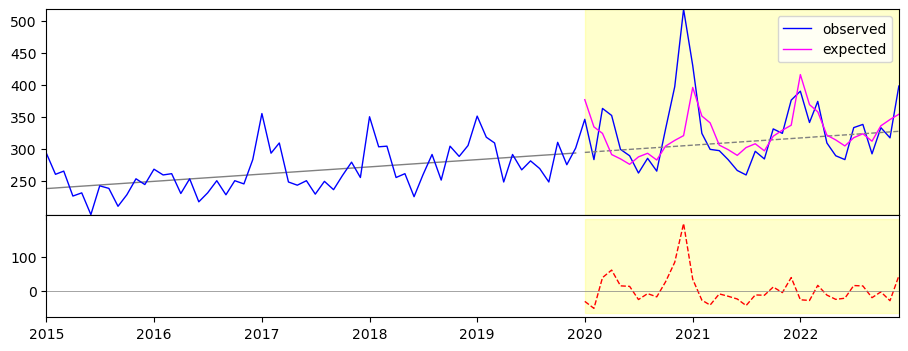

In [10]:
#Plots

fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(11,4),gridspec_kw={'height_ratios': [2,1]})

ax1.margins(0,0)
ax1.plot(linear_trend, c='grey', lw=1)
ax1.plot(pd.concat([y_pre,y_post],axis=0), c='blue',lw=1, label='observed')
ax1.fill_between(y_post.index, ax1.get_ylim()[0], ax1.get_ylim()[-1],color='yellow',alpha=0.2)        

ax1.plot(linear_trend_pred, c='grey',ls='--',lw=1)
ax1.plot(nb_pred, c='magenta', label='expected',lw=1)
ax1.legend()
ax1.set_xticklabels([])
ax1.set_yticks([250,300,350,400,450,500])

ax2.plot(excess, c='red', linestyle='--',lw=1)
ax2.axhline(0,xmin=0, lw=0.5,color='grey')
ax2.set_xlim(ax1.get_xlim()[0],ax1.get_xlim()[1])
ax2.fill_between(y_post.index, ax2.get_ylim()[0], ax2.get_ylim()[-1],color='yellow',alpha=0.2)        

ax2.set_yticks([0,100])
plt.subplots_adjust(wspace=0, hspace=0)

In [11]:
y=T['Lombardia','age 70-79'].reindex(T.index.get_level_values(2).unique()).fillna(0)
y_pre=y[:pre]
y_post=y[post:]


####### trend

lin_X=np.arange(len(y))
lin_X=np.stack([lin_X],axis=1)
lin_X=sm.add_constant(lin_X)

lin_X_pre=lin_X[:60]
coeff=sm.OLS(y_pre,lin_X_pre).fit().params
linear_trend=pd.Series(np.dot(lin_X_pre,coeff),index=y_pre.index)

lin_X_post=lin_X[60:]
linear_trend_pred=pd.Series(np.dot(lin_X_post,coeff),index=y_post.index)



####### seasonal

detrended=y_pre-linear_trend

seas=detrended.groupby(detrended.index.month).mean()
seas=seas-(seas.sum()/12)
seas.sum()

idx=np.linspace(1,12,12)
lin=np.linspace(1,12,12)

rep=splrep(idx, seas, s=500)
smooth_seas=pd.Series(splev(lin, rep), index=lin)

seas_rep=pd.concat([seas]*5)
seas_rep.index=y_pre.index
smooth_seas_rep=pd.concat([smooth_seas]*5)
smooth_seas_rep.index=y_pre.index

seas_pred=pd.Series(pd.concat([smooth_seas]*3).values, index=y_post.index)
naive_pred=linear_trend_pred+seas_pred

####### Negative binomial model

fullmatrix=pd.concat([linear_trend,seas_rep,y_pre],axis=1).dropna()
fullmatrix.columns=['trend','seasonal','total']

testmatrix=pd.concat([linear_trend_pred,seas_pred],axis=1).dropna()
testmatrix.columns=['trend','seasonal']

model=sm.GLM.from_formula(formula = 'total ~ trend + seasonal', data=fullmatrix,\
                    family=sm.families.Poisson())\
                    .fit()
params=model.params
model.summary()
nb_pred=model.predict(testmatrix)

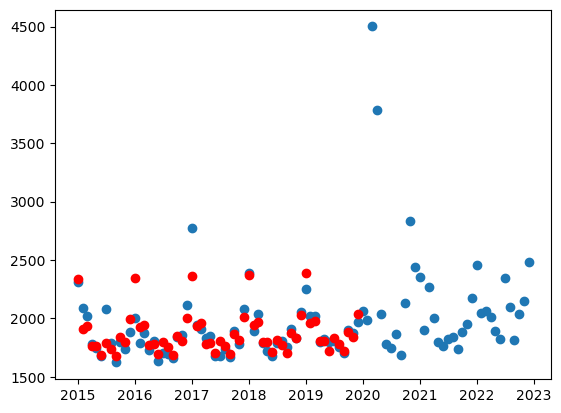

In [12]:
plt.scatter(y.index,y)
plt.scatter(y_pre.index, model.predict(fullmatrix.iloc[:,:-1]), color='red')

The excess mortality is defined as $\mathrm{observed} - \mathrm{expected}$. To compare the excess across different countries and age ranges one can either use percentage changes
$\frac{\mathrm{observed} - \mathrm{expected}}{\mathrm{expected}}$ or Z-scores.

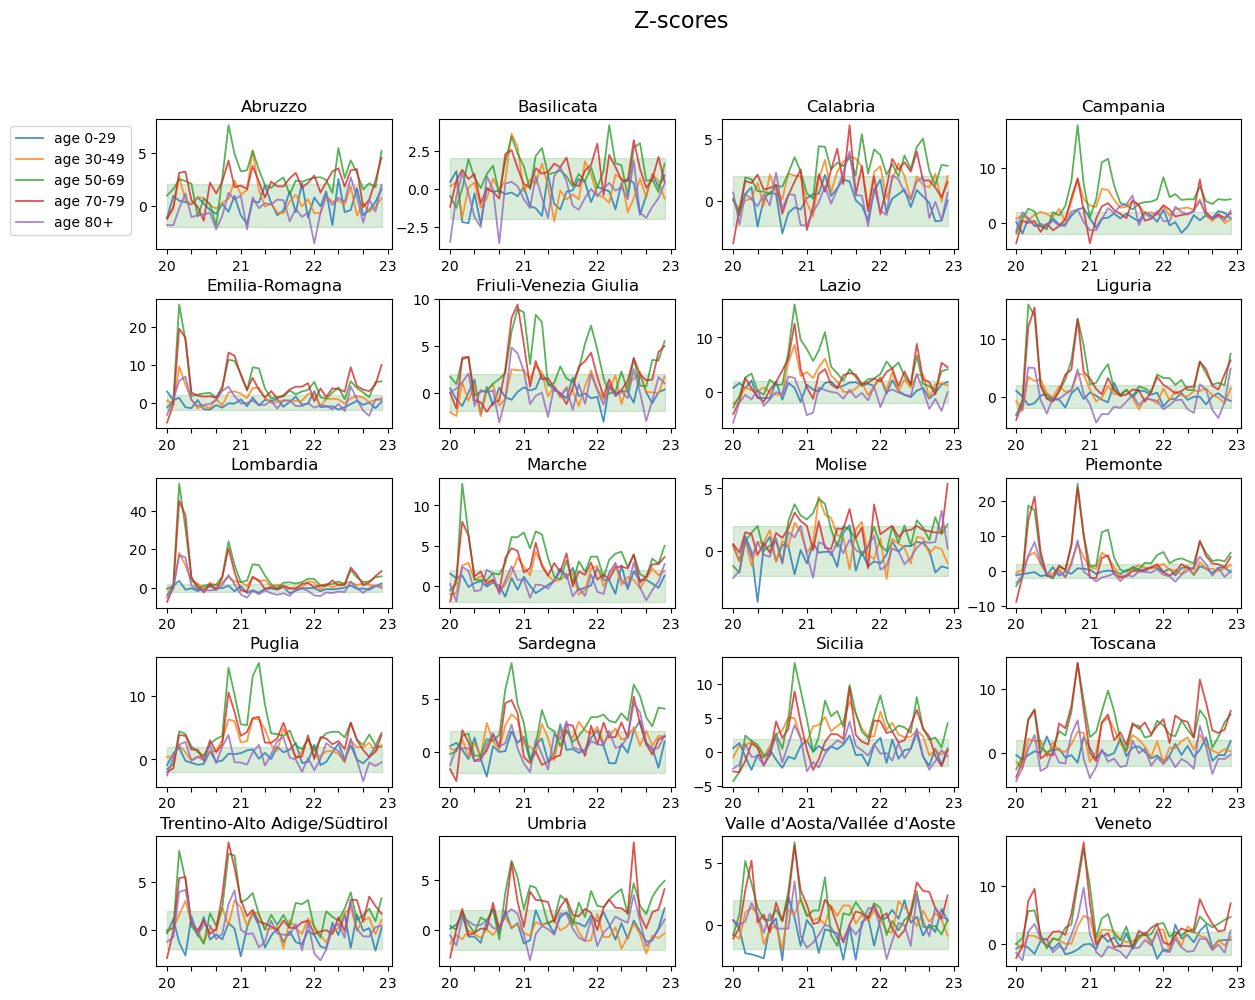

In [13]:
#PLOTS

fig,ax=plt.subplots(ncols=4,nrows=5,figsize=(14,11))
fig.suptitle('Z-scores', size=16)

for i in range(len(regions)):
    ax.flatten()[i].fill_between(poisson_zscores[(regions[i],ages[0])].index, -2,2, color='green',alpha=0.15)        
    for age in ages:
        ax.flatten()[i].plot(poisson_zscores[(regions[i],age)],alpha=0.8, lw=1.3,label=age)
        ax.flatten()[i].set_title(regions[i])
        ax.flatten()[i].set_xticks(ax.flatten()[i].get_xticks())
        ax.flatten()[i].set_xticklabels(['20','','','21','','','22','','','23'])
ax[0][0].legend(bbox_to_anchor=(-0.65,1),loc='upper left')
plt.subplots_adjust(wspace=0.2, hspace=0.38)


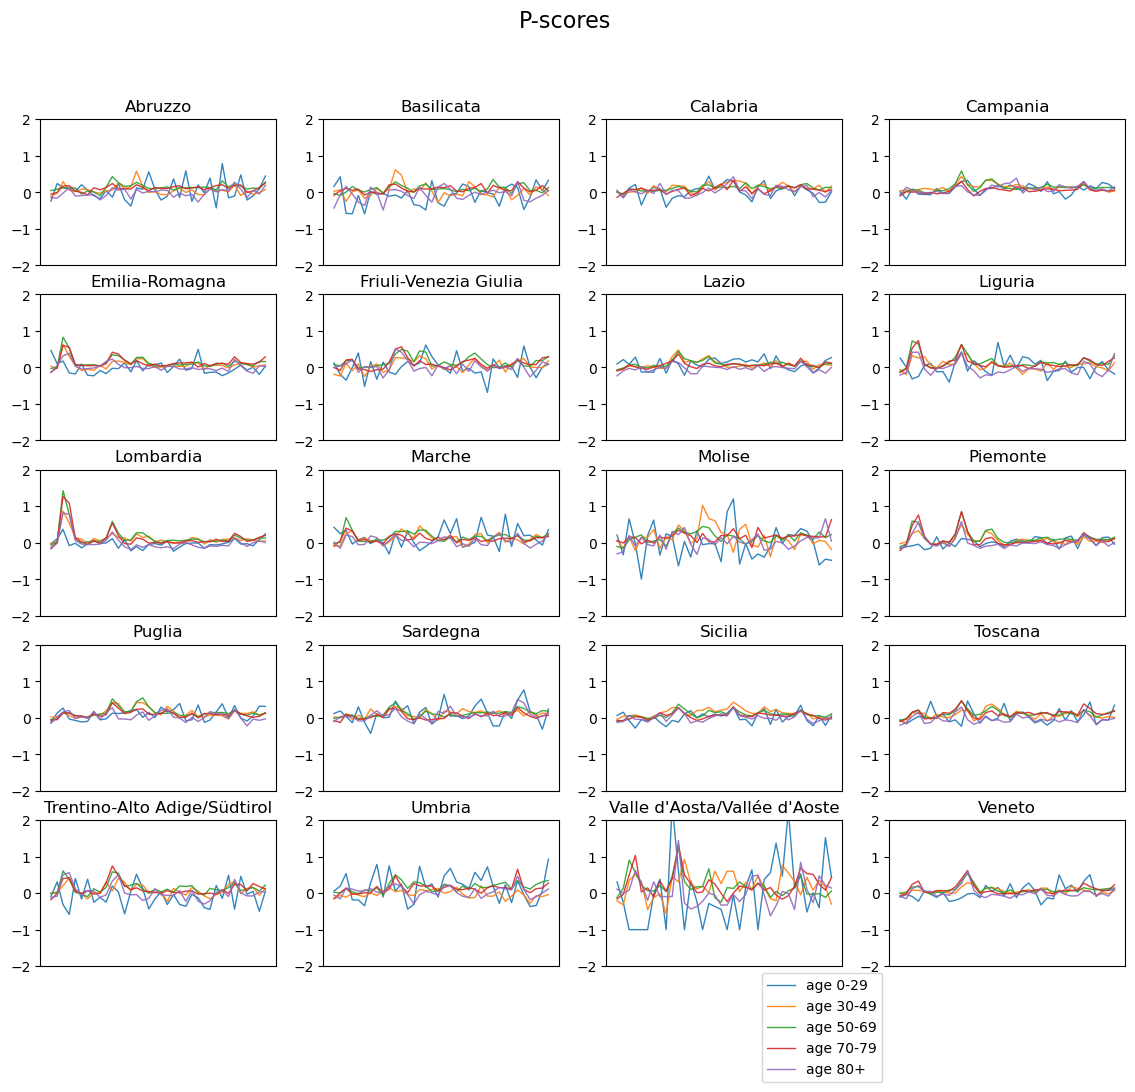

In [14]:
#PLOTS
fig,ax=plt.subplots(ncols=4,nrows=5,figsize=(14,11))
fig.suptitle('P-scores', size=16)

for i in range(len(regions)):
    for age in ages:
        ax.flatten()[i].plot(pscores[(regions[i],age)],alpha=0.9, lw=1,label=age)
        ax.flatten()[i].set_title(regions[i])
        ax.flatten()[i].set_ylim(-2,2)
        ax.flatten()[i].axes.get_xaxis().set_visible(False)
plt.legend(bbox_to_anchor=(0, 0))

Clearly the percentage changes for the young age classes in the smallest regions (Molise, Valle d'Aosta) are very noisy due to the small number of death cases.

## Excess deaths per province in 2020

In [15]:
full_data.head()

,region,province,age_class,M,F,T
date,,,,,,
2015-01-01,Abruzzo,Chieti,9,1,0,1
2015-01-01,Abruzzo,Chieti,16,0,1,1
2015-01-01,Abruzzo,Chieti,16,1,0,1
2015-01-01,Abruzzo,Chieti,16,1,1,2
2015-01-01,Abruzzo,Chieti,17,0,1,1


In [16]:
idx=pd.IndexSlice

per_province=full_data.groupby([full_data.index.year, full_data.index.month, 'province']).sum()['T']
per_province=per_province.loc[:,idx[2:9],:]
per_province=per_province.groupby([per_province.index.get_level_values(level=0),'province']).sum()

per_province_M=full_data.groupby([full_data.index.year, full_data.index.month, 'province']).sum()['M']
per_province_M=per_province_M.loc[:,idx[2:9],:]
per_province_M=per_province_M.groupby([per_province_M.index.get_level_values(level=0),'province']).sum()

per_province_F=full_data.groupby([full_data.index.year, full_data.index.month, 'province']).sum()['F']
per_province_F=per_province_F.loc[:,idx[2:9],:]
per_province_F=per_province_F.groupby([per_province_F.index.get_level_values(level=0),'province']).sum()

In [17]:
expected=per_province.loc[idx[2016:2019]].groupby(['province']).mean()
expected_M=per_province_M.loc[idx[2016:2019]].groupby(['province']).mean()
expected_F=per_province_F.loc[idx[2016:2019]].groupby(['province']).mean()

year2020=per_province.loc[idx[2020],:,:]
year2020_M=per_province_M.loc[idx[2020],:,:]
year2020_F=per_province_F.loc[idx[2020],:,:]

In [18]:
excess=100*((year2020-expected)/expected).sort_values(ascending=False)
excess_M=100*((year2020_M-expected_M)/expected).sort_values(ascending=False)
excess_F=100*((year2020_F-expected_F)/expected).sort_values(ascending=False)

In [19]:
full_data

,region,province,age_class,M,F,T
date,,,,,,
2015-01-01,Abruzzo,Chieti,9,1,0,1
2015-01-01,Abruzzo,Chieti,16,0,1,1
2015-01-01,Abruzzo,Chieti,16,1,0,1
2015-01-01,Abruzzo,Chieti,16,1,1,2
2015-01-01,Abruzzo,Chieti,17,0,1,1
...,...,...,...,...,...,...
2022-12-31,Veneto,Vicenza,19,0,1,1
2022-12-31,Veneto,Vicenza,19,1,0,1
2022-12-31,Veneto,Vicenza,20,0,1,1


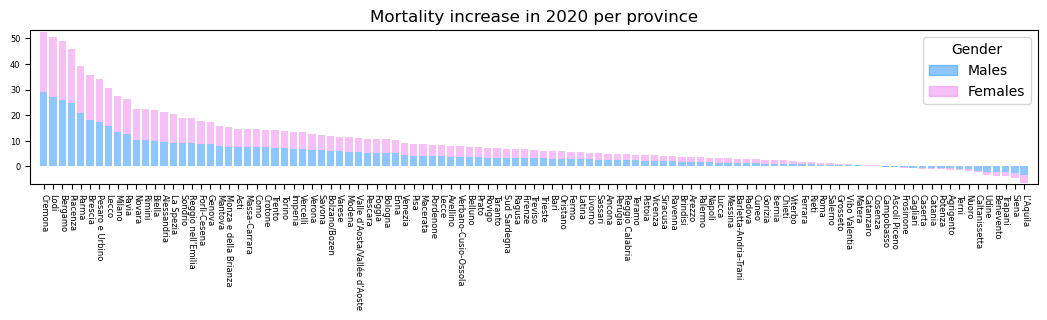

In [21]:
fig,ax=plt.subplots(figsize=(13,2))

ax.bar(excess_M.index, excess_F.values, bottom=excess_M.values, color='violet', alpha=0.5, linewidth = 0)
ax.bar(excess_M.index, excess_M.values, color='dodgerblue', linewidth = 0, alpha=0.5)

ax.set_xticks(ax.get_xticks(), list(excess_M.index), rotation=-90);
ax.tick_params(axis='both', labelsize=6)
ax.margins(0.01,0.01)
ax.set_title('Mortality increase in 2020 per province')

handles = [
    plt.Rectangle((0, 0), 1, 1, color='dodgerblue', alpha=0.5),
    plt.Rectangle((0, 0), 1, 1, color='violet', alpha=0.5)
]
labels = ['Males', 'Females']
ax.legend(handles, labels, title="Gender");